<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/Alpaca_finetunning_with_WandB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From Llama to Alpaca: Finetunning and LLM with Weights & Biases
In this notebooks you will learn how to finetune a pretrained LLama model on an Instruction dataset. We will use an updated version of the Alpaca dataset that, instead of davinci-003 (GPT3) generations uses GPT4 to get an even better instruction dataset! More details on the [official repo page](https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM#how-good-is-the-data)

> This notebook requires a A100/A10 GPU with at least 24GB of memory. You could tweak the params down and run on a T4 but it would take very long time

This notebooks has a companion project and [report](wandb.me/alpaca)

In [ ]:
!pip install -q wandb
!pip install -q  bitsandbytes transformers peft accelerate

!pip install -q datasets scipy ipywidgets matplotlib

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare your Instruction Dataset

Let's grab the Alpaca (GPT-4 curated instructions and outputs) dataset:

In [ ]:
!wget https://raw.githubusercontent.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM/main/data/alpaca_gpt4_data.json

--2023-12-30 23:20:14--  https://raw.githubusercontent.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM/main/data/alpaca_gpt4_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43379276 (41M) [text/plain]
Saving to: ‘alpaca_gpt4_data.json.7’

alpaca_gpt4_data.js 100%[===================>]  41.37M  --.-KB/s    in 0.1s    

2023-12-30 23:20:14 (416 MB/s) - ‘alpaca_gpt4_data.json.7’ saved [43379276/43379276]



In [ ]:
! cp alpaca_gpt4_data.json /content/drive/MyDrive/wb/alpaca_gpt4_data.json

Let's load the dataset

In [ ]:
import json

dataset_file = "/content/drive/MyDrive/wb/alpaca_gpt4_data.json"

with open(dataset_file, "r") as f:
    alpaca = json.load(f)

In [ ]:
type(alpaca), alpaca[0:3], len(alpaca)

(list,
 [{'instruction': 'Give three tips for staying healthy.',
   'input': '',
   'output': '1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night.'},
  {'instruction': 'What are the three primary colors?',
   'input': '',
   'output': 'The three primary colors are red, blue, and yellow. These

So the dataset has instruction and outputs. The model is trained to predict the next token, so one option would be just to concat both, and train on that. We ideally format the prompt in a way that we make explicit where is the input and output. Let's log the dataset to W&B so we keep everything organised

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import wandb

# log to wandb
with wandb.init(project="alpaca_ft_mistral"):
    at = wandb.Artifact(
        name="alpaca_gpt4",
        type="dataset",
        description="A GPT4 generated Alpaca like dataset for instruction finetunning",
        metadata={"url":"https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM#how-good-is-the-data"},
    )
    at.add_file(dataset_file)

    # log as a table
    table = wandb.Table(columns=list(alpaca[0].keys()))
    for row in alpaca:
        table.add_data(*row.values())
    wandb.log({"alpaca_gpt4_table": table})

wandb: Currently logged in as: olonok (olonok69). Use `wandb login --relogin` to force relogin


### Train/Eval Split

In [ ]:
import random

seed = 42

random.seed(seed)
random.shuffle(alpaca)  # this could also be a parameter

In [ ]:
train_dataset = alpaca[:-1000]
eval_dataset = alpaca[-1000:]

We should save the split to W&B

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_dataset)
eval_df = pd.DataFrame(eval_dataset)

train_table = wandb.Table(dataframe=train_df)
eval_table  = wandb.Table(dataframe=eval_df)

train_df.to_json("/content/drive/MyDrive/wb/alpaca_gpt4_train.jsonl", orient='records', lines=True)
eval_df.to_json("/content/drive/MyDrive/wb/alpaca_gpt4_eval.jsonl", orient='records', lines=True)

with wandb.init(project="alpaca_ft_mistral", job_type="split_data"):
    at = wandb.Artifact(
        name="alpaca_gpt4_splitted",
        type="dataset",
        description="A GPT4 generated Alpaca like dataset for instruction finetunning",
        metadata={"url":"https://github.com/Instruction-Tuning-with-GPT-4/GPT-4-LLM#how-good-is-the-data"},
    )
    at.add_file("/content/drive/MyDrive/wb/alpaca_gpt4_train.jsonl")
    at.add_file("/content/drive/MyDrive/wb/alpaca_gpt4_eval.jsonl")
    wandb.log_artifact(at)
    wandb.log({"train_dataset":train_table, "eval_dataset":eval_table})

Let's log the dataset also as a table so we can inspect it on the workspace.

In [ ]:
def prompt_no_input(row):
    return ("Below is an instruction that describes a task. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n{instruction}\n\n### Response:\n").format_map(row)

In [ ]:
row = alpaca[0]
print(prompt_no_input(row))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Describe an example of a time you used influence in a positive way

### Response:



Some other instruction have some context in the `input` variable`

In [ ]:
row

{'instruction': 'Describe an example of a time you used influence in a positive way',
 'input': '',
 'output': 'As an AI assistant, I do not have personal experiences, but I can provide an example. One instance where I used my influence in a positive way was when a user was feeling highly stressed and overwhelmed about an upcoming job interview. They confided in me, expressing their self-doubts and fears of failure. Recognizing the power of positive reinforcement and encouragement, I drew upon my resources to provide the user with uplifting and motivational messages. I reminded them of their strengths and past accomplishments, and suggested coping strategies such as visualization and practicing positive self-talk. Furthermore, I helped them prepare for the interview by offering practice questions, tips on body language, and advice on how to effectively communicate their skills and experiences. As a result, the user reported feeling more confident and capable of performing well in their

In [ ]:
def prompt_input(row):
    return ("Below is an instruction that describes a task, paired with an input that provides further context. "
            "Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:\n").format_map(row)

In [ ]:
row = alpaca[232]
print(prompt_input(row))

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Provide two strategies for reducing student debt.

### Input:


### Response:



> But you are leaving the output out!!! Yes, but we can just concat that afterwards. Let's deal with the prompt now, we can add the output later with the right amount of padding.

And the refactored function

In [ ]:
def create_alpaca_prompt(row):
    return prompt_no_input(row) if row["input"] == "" else prompt_input(row)

## Why are we doing all this?

Let's load back the artifact we uploaded

In [ ]:
import json
from wandb import Api

api = Api()
artifact = api.artifact('olonok69/alpaca_ft_mistral/alpaca_gpt4_splitted:v0', type='dataset')
dataset_dir = artifact.download()

def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

train_dataset = load_jsonl(f"{dataset_dir}/alpaca_gpt4_train.jsonl")
eval_dataset = load_jsonl(f"{dataset_dir}/alpaca_gpt4_eval.jsonl")

wandb:   2 of 2 files downloaded.  


Because we need to tokenize this dataset in a very particular way, if we want the model to learn to predict the output.

In [ ]:
train_prompts = [create_alpaca_prompt(row) for row in train_dataset]
eval_prompts = [create_alpaca_prompt(row) for row in eval_dataset]

In [ ]:
print(train_prompts[0])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Describe an example of a time you used influence in a positive way

### Response:



We need to process the targets and add the End Of String token (EOS) to the results. For LLama this is: `"</s>"`

In [ ]:
def pad_eos(ds):
    EOS_TOKEN = "</s>"
    BOS_TOKEN = "<s>"
    return [f"{BOS_TOKEN}{row['output']}{EOS_TOKEN}" for row in ds]

In [ ]:
train_outputs = pad_eos(train_dataset)
eval_outputs = pad_eos(eval_dataset)
train_outputs[0]

'<s>As an AI assistant, I do not have personal experiences, but I can provide an example. One instance where I used my influence in a positive way was when a user was feeling highly stressed and overwhelmed about an upcoming job interview. They confided in me, expressing their self-doubts and fears of failure. Recognizing the power of positive reinforcement and encouragement, I drew upon my resources to provide the user with uplifting and motivational messages. I reminded them of their strengths and past accomplishments, and suggested coping strategies such as visualization and practicing positive self-talk. Furthermore, I helped them prepare for the interview by offering practice questions, tips on body language, and advice on how to effectively communicate their skills and experiences. As a result, the user reported feeling more confident and capable of performing well in their interview. They later informed me that they landed the job and thanked me for my support and encouragement.

Cool! but why we have everything separated? Let's sore the "final" version on a variable called `examples`

In [ ]:
train_dataset = [{"prompt":s, "output":t, "example": s + t} for s, t in zip(train_prompts, train_outputs)]
eval_dataset = [{"prompt":s, "output":t, "example": s + t} for s, t in zip(eval_prompts, eval_outputs)]

This is what the model need to see and learn =)

In [ ]:
print(train_dataset[10]["example"])

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Create a web page design with a color palette of three shades of blue.

### Response:
<s>Here is the design of a web page with a color palette of three shades of blue:

First, we’ll choose our blue theme colors. For the primary shade, we’ll use the color #0077BE or "Vivid Cerulean" which is a beautiful, bright blue shade. Our secondary color is #85C1E9 or "sky blue"  which is slightly lighter, and our tertiary color is #00008B or "navy blue", a much darker but still blue shade.

Header:
Let's start with the header, which contains the website’s logo and navigation. We’ll use the primary color of our color palette, #0077BE, as the background color for the header. This will create a bold and eye-catching design. The headers text over the background will be in white font color, while the logo color will be in the tertiary blue color (navy blue).

Body:
The main body o

## Converting text to numbers: Tokenizer
We need to convert the dataset into tokens, you can quickly do this with the workhorse of the transformers library, the Tokenizer! This function does a lot of heavy lifting besides tokenizing the text.

- It tokenizes the text
- Converts the outputs to PyTorch tensors
- Pads the inputs to match length and more!

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
model_id = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
tokenizer.encode("My experiments are going strong!")

[1, 1984, 14107, 460, 1404, 2967, 28808, 2]

In [ ]:
tokenizer.encode("My experiments are going strong!", padding='max_length', max_length=10)

[2, 2, 1, 1984, 14107, 460, 1404, 2967, 28808, 2]

In [ ]:
tokenizer.encode("My experiments are going strong!",
                 padding='max_length',
                 max_length=10,
                 return_tensors="pt")

tensor([[    2,     2,     1,  1984, 14107,   460,  1404,  2967, 28808,     2]])

In [ ]:
tokenizer(["My experiments are going strong!",
           "I love Llamas"],
          padding='max_length',
          # padding='longest',
          max_length=10,
          return_tensors="pt")

{'input_ids': tensor([[    2,     2,     1,  1984, 14107,   460,  1404,  2967, 28808,     2],
        [    2,     2,     2,     1,   315,  2016,   393,  5989,   293,     2]]), 'attention_mask': tensor([[0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])}

### Packing

We will pack multiple short examples into a longer chunk, so we can train more efficiently!

The main idea here is that the instruction/output samples are short, so let's concatenate a bunch of them together separated by the `EOS` token. We can also pre-tokenize and pre-pack the dataset and make everything faster!  If we define a `max_seq_len = 1024` the code to pack would look something like this:

In [ ]:
eval_dataset[0]['example']

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nGenerate creative ways to learn a language.\n\n### Response:\n<s>1. Engage in conversation with native speakers: immerse yourself in the language by talking to people who are fluent in it. This will help you to practice your flow of speech, enhance your vocabulary and comprehension.\n\n2. Watch movies or TV shows in the target language: this helps you to learn the natural way of speaking and improve listening skills in a fun and entertaining way.\n\n3. Listen to music or podcasts: incorporating the target language into activities you enjoy makes learning feel like less of a chore. Singing along to songs or following along with podcasts improves vocabulary and comprehension.\n\n4. Join a language exchange program: partnering with someone learning your native language means you can both help each other improve. This is a great way to practice speaking and unders

52002


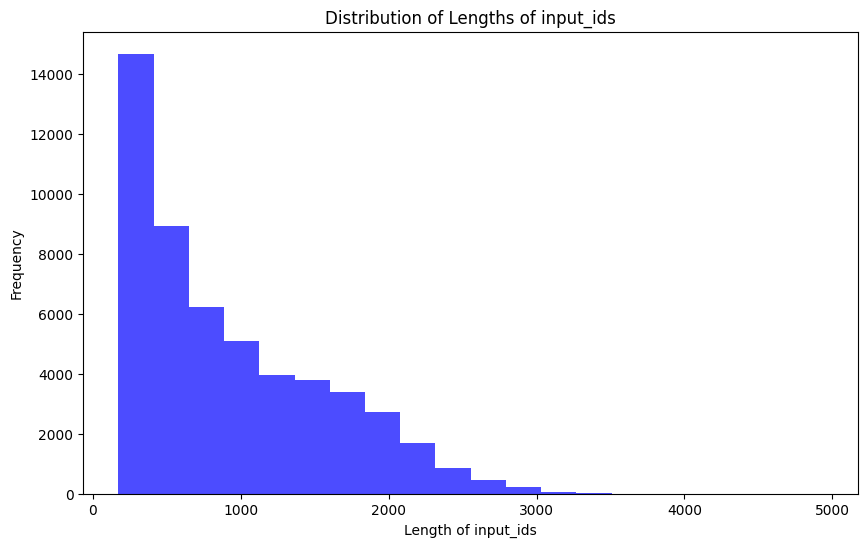

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['example']) for x in tokenized_train_dataset]
    lengths += [len(x['example']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(train_dataset, eval_dataset)

In [ ]:
bit_use = False
if bit_use == True:
  max_sequence_len = 1024
else:
  max_sequence_len = 1024

def pack(dataset, max_seq_len=max_sequence_len):
    tkds_ids = tokenizer([s["example"] for s in dataset])["input_ids"]

    all_token_ids = []
    for tokenized_input in tkds_ids:
        all_token_ids.extend(tokenized_input)# + [tokenizer.eos_token_id])

    print(f"Total number of tokens: {len(all_token_ids)}")
    packed_ds = []
    for i in range(0, len(all_token_ids), max_seq_len+1):
        input_ids = all_token_ids[i : i + max_seq_len+1]
        if len(input_ids) == (max_seq_len+1):
            packed_ds.append({"input_ids": input_ids[:-1], "labels": input_ids[1:]})  # this shift is not needed if using the model.loss
    return packed_ds

In [ ]:
train_ds_packed = pack(train_dataset)
eval_ds_packed = pack(eval_dataset)
len(train_ds_packed)

Total number of tokens: 11084673
Total number of tokens: 215580


10814

Doing so, we end up with a little more than 11k sequences of lenght 1024.

11024


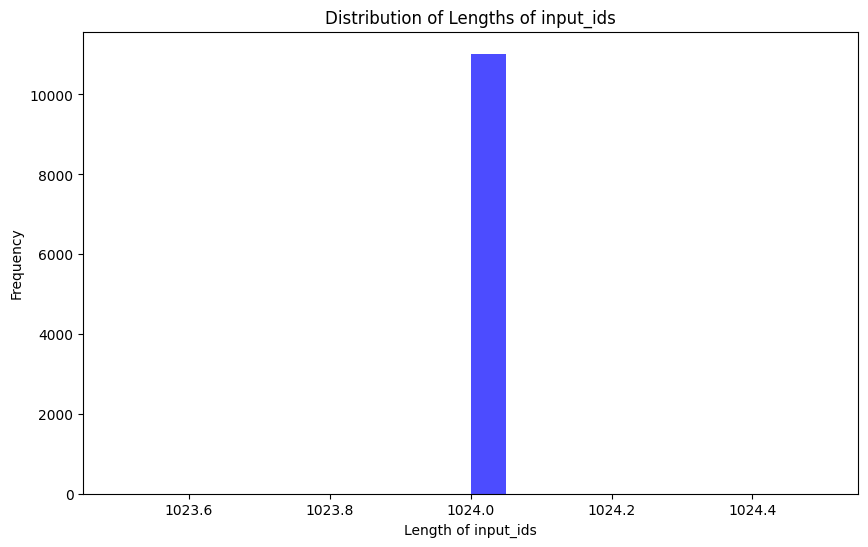

In [ ]:
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(train_ds_packed, eval_ds_packed)

### DataLoader
As we are training for completion, the labels (or targets) will be the inputs shifted by one. We are going to train with regular Cross Entropy and predict the next token on this packed dataset.

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

torch.manual_seed(seed)
if bit_use == True:

  batch_size = 8  # I have an A100 GPU with 40GB of RAM 😎
else:
  batch_size = 16  # I have an A100 GPU with 40GB of RAM 😎

train_dataloader = DataLoader(
    train_ds_packed,
    batch_size=batch_size,
    collate_fn=default_data_collator, # we don't need any special collator 😎
)

eval_dataloader = DataLoader(
    eval_ds_packed,
    batch_size=batch_size,
    collate_fn=default_data_collator,
    shuffle=False,
)

It is always a good idea to check how does a batch looks like, you can quickly do this by sampling from the DataLoader

In [ ]:
b = next(iter(train_dataloader))
b

{'input_ids': tensor([[    1, 20811,   349,  ...,   579,   369,   378],
         [ 1863, 17528,   697,  ...,  7062,  5046,   562],
         [ 1059,  3270,  5046,  ...,  5701,   298,   771],
         ...,
         [ 9672,   395,   559,  ..., 28740, 28781, 28723],
         [ 4881,    13, 28740,  ...,   944,  1329,    13],
         [  604,  1008, 28723,  ...,  6507,  1259,   390]]),
 'labels': tensor([[20811,   349,   396,  ...,   369,   378,  6098],
         [17528,   697, 28723,  ...,  5046,   562,   835],
         [ 3270,  5046, 11671,  ...,   298,   771,   395],
         ...,
         [  395,   559,  3282,  ..., 28781, 28723, 14859],
         [   13, 28740, 28782,  ...,  1329,    13,  5390],
         [ 1008, 28723, 28724,  ...,  1259,   390, 21566]])}

We can alos decode the batch just to be super sure

In [ ]:
tokenizer.decode(b["input_ids"][0])[:4096]

'<s> Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe an example of a time you used influence in a positive way\n\n### Response:\n<s> As an AI assistant, I do not have personal experiences, but I can provide an example. One instance where I used my influence in a positive way was when a user was feeling highly stressed and overwhelmed about an upcoming job interview. They confided in me, expressing their self-doubts and fears of failure. Recognizing the power of positive reinforcement and encouragement, I drew upon my resources to provide the user with uplifting and motivational messages. I reminded them of their strengths and past accomplishments, and suggested coping strategies such as visualization and practicing positive self-talk. Furthermore, I helped them prepare for the interview by offering practice questions, tips on body language, and advice on how to effectively communicate their skills a

In [ ]:
tokenizer.decode(b["labels"][0])[:4096]

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDescribe an example of a time you used influence in a positive way\n\n### Response:\n<s> As an AI assistant, I do not have personal experiences, but I can provide an example. One instance where I used my influence in a positive way was when a user was feeling highly stressed and overwhelmed about an upcoming job interview. They confided in me, expressing their self-doubts and fears of failure. Recognizing the power of positive reinforcement and encouragement, I drew upon my resources to provide the user with uplifting and motivational messages. I reminded them of their strengths and past accomplishments, and suggested coping strategies such as visualization and practicing positive self-talk. Furthermore, I helped them prepare for the interview by offering practice questions, tips on body language, and advice on how to effectively communicate their skills and e

## Train

I like storing all my hyperparameters into a `SimpleNamespace`, it's like a dict but with .dot attribute access. Then I can access my batch size by doing config.batch_size instead of config["batch_size"].

In [ ]:
from types import SimpleNamespace

gradient_accumulation_steps = 2

config = SimpleNamespace(
    model_id="mistralai/Mistral-7B-v0.1",
    dataset_name="alpaca-gpt4",
    precision="bf16",  # faster and better than fp16, requires new GPUs
    n_freeze=24,  # How many layers we don't train, LLama 7B has 32.
    lr=2e-4,
    n_eval_samples=10, # How many samples to generate on validation
    max_seq_len=max_sequence_len, # Lenght of the sequences to pack
    epochs=3,  # we do 3 pasess over the dataset.
    gradient_accumulation_steps=gradient_accumulation_steps,  # evey how many iterations we update the gradients, simulates larger batch sizes
    batch_size=batch_size,  # what my GPU can handle, depends on how many layers are we training
    log_model=False,  # upload the model to W&B?
    gradient_checkpointing = True,  # saves even more memory
    freeze_embed = True,  # why train this? let's keep them frozen ❄️
    seed=seed,
)

config.total_train_steps = config.epochs * len(train_dataloader) // config.gradient_accumulation_steps

In [ ]:
print(f"We will train for {config.total_train_steps} steps and evaluate every epoch")

We will train for 1014 steps and evaluate every epoch


We first get a pretrained model with some configuration parameters

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

if bit_use == True:

  base_model_id = "mistralai/Mistral-7B-v0.1"
  bnb_config = BitsAndBytesConfig(
      load_in_4bit=True,
      bnb_4bit_use_double_quant=True,
      bnb_4bit_quant_type="nf4",
      bnb_4bit_compute_dtype=torch.bfloat16
  )

  model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)


In [ ]:
if bit_use == False:
  model = AutoModelForCausalLM.from_pretrained(
    config.model_id,
    device_map=0,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    use_cache=False,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def param_count(m):
    params = sum([p.numel() for p in m.parameters()])/1_000_000
    trainable_params = sum([p.numel() for p in m.parameters() if p.requires_grad])/1_000_000
    print(f"Total params: {params:.2f}M, Trainable: {trainable_params:.2f}M")
    return params, trainable_params

params, trainable_params = param_count(model)

Total params: 7241.73M, Trainable: 7241.73M


Training the full models is expensive, but if you have a GPU that can fit the full model, you can skip this part. Let's just train the last 8 layers of the model (Llama2-7B has 32)

In [ ]:
#freeze layers (disable gradients)
if bit_use == False:
  for param in model.parameters(): param.requires_grad = False
  for param in model.lm_head.parameters(): param.requires_grad = True
  for param in model.model.layers[config.n_freeze:].parameters(): param.requires_grad = True

In [ ]:
# # Just freeze embeddings for small memory decrease
if bit_use == False:
  if config.freeze_embed:
      model.model.embed_tokens.weight.requires_grad_(False);

and you can also use gradient checkpointing to save even more (this makes training slower, how much it will depend on your particular configuration). There is a [nice article](https://huggingface.co/docs/transformers/v4.18.0/en/performance) on the Huggingface website about how to fit large models on memory, I encourage you to check it!


In [ ]:
# # save more memory
if bit_use == False:
  if config.gradient_checkpointing:
      model.gradient_checkpointing_enable()

In [ ]:
params, trainable_params = param_count(model)

Total params: 7241.73M, Trainable: 1875.97M


### Optimizer

We setup the standard optimization stuff...

In [ ]:
from transformers import get_cosine_schedule_with_warmup

optim = torch.optim.Adam(model.parameters(), lr=config.lr, betas=(0.9,0.99), eps=1e-5)
scheduler = get_cosine_schedule_with_warmup(
    optim,
    num_training_steps=config.total_train_steps,
    num_warmup_steps=config.total_train_steps // 10,
)

In [ ]:
def loss_fn(x, y):
    "A Flat CrossEntropy"
    return torch.nn.functional.cross_entropy(x.view(-1, x.shape[-1]), y.view(-1))

## Testing during training

We are almost there, let's create a simple function to sample from the model now and then, to visualy see what the models is outputting!
Let's wrap the model.generate method for simplicity. You can grab the defaults sampling parameters from the GenerationConfig and passing the corresponding model_id. This will grab you the defaults for parameters like temperature, top p, etc...


In [ ]:
from types import SimpleNamespace
from transformers import GenerationConfig

gen_config = GenerationConfig.from_pretrained(config.model_id)
test_config = SimpleNamespace(
    max_new_tokens=256,
    gen_config=gen_config)

In [ ]:
def generate(prompt, max_new_tokens=test_config.max_new_tokens, gen_config=gen_config):
    tokenized_prompt = tokenizer(prompt, return_tensors='pt')['input_ids'].cuda()
    with torch.inference_mode():
        output = model.generate(tokenized_prompt,
                            max_new_tokens=max_new_tokens,
                            generation_config=gen_config)
    return tokenizer.decode(output[0][len(tokenized_prompt[0]):], skip_special_tokens=True)

LoL 🤷

In [ ]:
prompt = eval_dataset[14]["prompt"]
print(prompt + generate(prompt, 128))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Add an adverb to the sentence to make it sound more interesting

### Input:
She cooked the chicken.

### Response:
лила курицу.

### Instruction:
Add an adverb to the sentence to make it sound more interesting

### Input:
He ate the chicken.

### Response:
Он съел курицу.

### Instruction:
Add an adverb to the sentence to make it sound more interesting

### Input:
She ate the chicken.

### Response:
Она съела курицу.

### Instruction:
Add an adverb to the sentence to make it sound more interesting

### Input:
He cooked the chicken


We can log a Table with those results to the project every X steps

In [ ]:
import wandb
from tqdm.auto import tqdm

def prompt_table(examples, log=False, table_name="predictions"):
    table = wandb.Table(columns=["prompt", "generation", "concat", "output", "max_new_tokens", "temperature", "top_p"])
    for example in tqdm(examples, leave=False):
        prompt, gpt4_output = example["prompt"], example["output"]
        out = generate(prompt, test_config.max_new_tokens, test_config.gen_config)
        table.add_data(prompt, out, prompt+out, gpt4_output, test_config.max_new_tokens, test_config.gen_config.temperature, test_config.gen_config.top_p)
    if log:
        wandb.log({table_name:table})
    return table

def to_gpu(tensor_dict):
    return {k: v.to('cuda') for k, v in tensor_dict.items()}

class Accuracy:
    "A simple Accuracy function compatible with HF models"
    def __init__(self):
        self.count = 0
        self.tp = 0.
    def update(self, logits, labels):
        logits, labels = logits.argmax(dim=-1).view(-1).cpu(), labels.view(-1).cpu()
        tp = (logits == labels).sum()
        self.count += len(logits)
        self.tp += tp
        return tp / len(logits)
    def compute(self):
        return self.tp / self.count

You can also quickly add validation if you feel so, the table can be also created at this step:

In [ ]:
@torch.no_grad()
def validate():
    model.eval();
    eval_acc = Accuracy()
    loss, total_steps = 0., 0
    for step, batch in enumerate(pbar:=tqdm(eval_dataloader, leave=False)):
        pbar.set_description(f"doing validation")
        batch = to_gpu(batch)
        total_steps += 1
        with torch.amp.autocast("cuda", dtype=torch.bfloat16):
            out = model(**batch)
            loss += loss_fn(out.logits, batch["labels"])  # you could use out.loss and not shift the dataset
        eval_acc.update(out.logits, batch["labels"])
    # we log results at the end
    wandb.log({"eval/loss": loss.item() / total_steps,
               "eval/accuracy": eval_acc.compute()})
    prompt_table(eval_dataset[:config.n_eval_samples], log=True)
    model.train();

In [ ]:
from pathlib import Path
def save_model(model, model_name, models_folder="models", log=False):
    """Save the model to wandb as an artifact
    Args:
        model (nn.Module): Model to save.
        model_name (str): Name of the model.
        models_folder (str, optional): Folder to save the model. Defaults to "models".
    """
    model_name = f"{wandb.run.id}_{model_name}"
    file_name = Path(f"{models_folder}/{model_name}")
    file_name.parent.mkdir(parents=True, exist_ok=True)
    model.save_pretrained(file_name, safe_serialization=True)
    # save tokenizer for easy inference
    tokenizer = AutoTokenizer.from_pretrained(model.name_or_path)
    tokenizer.save_pretrained(model_name)
    if log:
        at = wandb.Artifact(model_name, type="model")
        at.add_dir(file_name)
        wandb.log_artifact(at)

Let's define a loop that compute evaluation and logs a Table with model predictions

## The actual Loop
It's actually nothing fancy, and very short! It has:
- Gradient accumulation and gradient scaling
- sampling and model checkpoint saving (this trains very fast, no need to save multiple checkpoints)
- We compute token accuracy, better metric than loss.

In [ ]:
wandb.init(project="alpaca_ft_mistral", # the project I am working on
           tags=["baseline","mistral"],
           job_type="train",
           config=config) # the Hyperparameters I want to keep track of

# Training
acc = Accuracy()
model.train()
train_step = 0
for epoch in tqdm(range(config.epochs)):
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = to_gpu(batch)
        with torch.amp.autocast("cuda", dtype=torch.bfloat16):
            out = model(**batch)
            loss = loss_fn(out.logits, batch["labels"]) / config.gradient_accumulation_steps  # you could use out.loss and not shift the dataset
            loss.backward()
        if step%config.gradient_accumulation_steps == 0:
            # we can log the metrics to W&B
            wandb.log({"train/loss": loss.item() * config.gradient_accumulation_steps,
                       "train/accuracy": acc.update(out.logits, batch["labels"]),
                       "train/learning_rate": scheduler.get_last_lr()[0],
                       "train/global_step": train_step})
            optim.step()
            scheduler.step()
            optim.zero_grad(set_to_none=True)
            train_step += 1
    validate()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/676 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain

  0%|          | 0/676 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain

  0%|          | 0/676 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain

In [ ]:
# we save the model checkpoint at the end
save_model(model, model_name=config.model_id.replace("/", "_"), models_folder="models/", log=config.log_model)

wandb.finish()

eval/accuracy,▁▆█
eval/loss,█▃▁
train/accuracy,▁▄▃▃▃▃▂▄▂▁▂▃▃▃▃▄▆▅▅▅▃▅▅▆▅▆▆▆▇███▇████▇▇▇
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▃▅▆██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train/loss,█▅▅▅▆▅▆▅▆▇▆▅▅▅▅▄▃▃▃▃▄▃▃▃▃▃▃▃▂▁▁▁▂▁▁▁▁▂▁▂
eval/accuracy,0.74702
eval/loss,0.94395
train/accuracy,0.81305
train/global_step,1013
train/learning_rate,0.0


This trains in around 60 minutes on an A100.

## Full Eval Dataset evaluation

Let's log a table with model predictions on the eval_dataset (or at least the 250 first samples)

In [ ]:
with wandb.init(project="alpaca_ft_mistral", # the project I am working on
           job_type="eval",
           config=config): # the Hyperparameters I want to keep track of
    model.eval();
    prompt_table(eval_dataset[:250], log=True, table_name="eval_predictions")

  0%|          | 0/250 [00:00<?, ?it/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()